# Practical exercise #2

## Text annotation by prompting an LLM

This is the option 2 out of 2 for practical exercises, for the JYU LLM methods course.

The example code in this notebook does the following:

- Load an example dataset, that has news articles about the war in Ukraine from a Russian and British source.
- Define a system prompt and user prompt for extracting sources of information from news articles.
- Test out the prompt on individual news articles and print the results.
- Run the prompt on the full dataset, including hundreds of articles.
- Visualise the results, showing most common named sources of information and categorisation of these into types.

### Choice of language model

The University currently doesn't have the specialised hardware (GPUs) easily available for teaching. That is why running language models through cloud providers is the easiest option.

The notebook is by default using OpenAI's GPT-3.5-Turbo model, ran in the cloud. This model is closed and proprietary, so sending sensitive research material to it is not advised. GPT-3.5 was chosen because its cheap to run. It also understands several languages, so it can, for instance, process text in Finnish.

The notebook also contains example code for running an open source model (Llama-2-70b) with another cloud provider.


### Options for how to do exercise

Feel free to use the example code and data in this notebook in a way that relates to your research interests or you find valuable. Some suggestions on what to do:

- You may choose another dataset of set of texts, and try to adopt the prompt to see if the LLM is able to annotate the text in a useful way. Note that GPT-3.5 can handle input (prompt + documents) of about 2,000 words.
- You may take the example dataset and try to extract some other type of information from it, by writing your own prompts.
- You may take the example dataset, and try to understand where the model makes errors. Can you improve the prompts so that those errors don't take place?
- What other kind of text annotation or categorisation could you achieve with LLMs, possibly even using a more user-friendly interface than notebooks (such as one of the many chat-based interfaces).

Locations for finding alternative public datasets:
  - [HuggingFace](https://huggingface.co/datasets?task_categories=task_categories%3Atext-classification)
  - [Zenodo](https://zenodo.org/search?page=1&size=20&q=&type=dataset)

# Libraries

In [ ]:
%%capture
!pip install openai retrying

In [ ]:
from tqdm.notebook import tqdm, tqdm_notebook  # Import tqdm_notebook for notebook environment
tqdm_notebook()
tqdm_notebook.pandas()
import pandas as pd
import json

env_vars = {line.split('=')[0]: line.split('=')[1].strip() for line in open('../shared/.env')}

# Load data

In [ ]:
data=pd.read_csv('iz_ru_theguardian_100.csv')

# Set the option to display full text columns
pd.set_option('display.max_colwidth', 500)
data.head()

,Unnamed: 0,Source,Title,Text_English,Text_Russian,Authors,Publication Date,url,word_count
0,0,iz.ru,«Известия» рассказали об украинских складах оружия в шахтах под Артемовском,"In the liberated territory in the area of ​​Artemovsk (Ukrainian name - Bakhmut), Russian fighters conduct an “inventory” of Ukrainian military facilities. Izvestia correspondents visited the underground ""Caches"", saw weapons reserves and found out whether their Russian troops could use their troops.\n\nThe fighters found Ukrainian weapons at a depth of more than 150 m in the former salt mines of Artemovsk. One of these objects was built during the time of the USSR with the expectation that ...","На освобожденной территории в районе Артемовска (украинское название — Бахмут) российские бойцы проводят «инвентаризацию» украинских военных объектов. Корреспонденты «Известий» побывали в подземном «схроне», увидели запасы оружия и узнали, смогут ли использовать их российские войска.\n\nБойцы находили украинские склады оружия на глубине более 150 м в бывших соляных шахтах Артемовска. Один из таких объектов построили еще во времена СССР с расчетом на то, что степень их защиты позволит выдержа...",NaN,2023-05-03 04:46:00+03:00,https://iz.ru/1507422/2023-05-03/izvestiia-rasskazali-ob-ukrainskikh-skladakh-oruzhiia-v-shakhtakh-pod-artemovskom,204
1,1,iz.ru,Зеленский назвал обстановку под Артемовском перманентно сложной,"The Armed Forces of Ukraine (Armed Forces) operating in the area of ​​Artemovsk (Ukrainian name - Bakhmut) are in a difficult situation. On Monday, February 27, said Ukrainian leader Vladimir Zelensky.\n\n“Of course, I constantly remain in touch with the command. <...> In the Bakhmut direction, the situation becomes constantly difficult, ”the head of state noted in a video message.\n\nEarlier on this day, the acting head of the Donetsk People’s Republic (DPR) Denis Pushilin said that Russian...","Вооруженные силы Украины (ВСУ), действующие в районе Артемовска (украинское название — Бахмут), находятся в тяжелом положении. Об этом в понедельник, 27 февраля, заявил украинский лидер Владимир Зеленский.\n\n«Конечно, постоянно остаюсь на связи с командованием. <…> На бахмутском направлении ситуация становится постоянно сложной», — отметил глава государства в видеообращении.\n\nРанее в этот день врио главы Донецкой Народной Республики (ДНР) Денис Пушилин сообщил, что российские силы контрол...",NaN,2023-02-28 01:05:00+03:00,https://iz.ru/1476246/2023-02-28/zelenskii-nazval-obstanovku-pod-artemovskom-permanentno-slozhnoi,303
2,2,iz.ru,Жительница Артемовска рассказала об уничтожении района города украинскими боевиками,"In just three days, nationalists of Ukraine destroyed the whole residential area of ​​Artemovsk (Ukrainian name - Bakhmut) Stupi, destroying all houses during the retreat from there. On Thursday, March 23, a resident of the city Irina Turova, evacuated by Russian troops, told.\n\nAccording to her, the massive bombing of the district were held on February 25 and 26.\n\n“I don’t remember, it was either in the morning, or after lunch - mines began to fly, and they threw them from the side of“ T...","Националисты Украины буквально за три дня уничтожили целый жилой район Артемовска (украинское название — Бахмут) Ступки, разрушив при отступлении оттуда все дома. Об этом в четверг, 23 марта, рассказала эвакуированная российскими войсками жительница города Ирина Турова.\n\nПо ее словам, массированные бомбардировки района проводились 25 и 26 февраля.\n\n«Я не помню, это было или утром, или после обеда — начали летать мины, и кидали их со стороны «Цветмета» (Артемовский завод по обработке цвет...",NaN,2023-03-23 07:44:41+03:00,https://iz.ru/1487314/2023-03-23/zhitelnitca-artemovska-rasskazala-ob-unichtozhenii-raiona-goroda-ukrainskimi-boevikami,380
3,3,iz.ru,В Госдуме ответили на идею ЕС наладить совместные закупки оружия для Украины,"The European Union (EU) wants to put pressure on European countries that do not want to transfer weapons to Ukraine. T

In [ ]:
data['Source'].value_counts(dropna=False)

iz.ru              497
theguardian.com    336
Name: Source, dtype: int64

# Define prompts

The cells below define the prompts that are sent to language models. These are instructions that tell the model what to do. In addition to the prompts here, the example code attaches a news article to the prompt sent to the model.

System prompts are used to guide the overall tone, style, and content of the generated response. User prompts are used to ask questions, make statements, or initiate interactions with the model.


In [ ]:
system_prompt="""
You are an expert JSON builder, designed extract information from the provided input and to provide a response in a machine readable format.

You are able to respond to the User and JSON strings. All of your communication is performed using this JSON format. The Assistant will provide data in as simple as possible JSON form, for instance a simple list, when requested.

Do not start your response with "Sure!", or "Here is ..." or any other string that is not JSON.
"""

In [ ]:
user_prompt_template="""
Below is a news article. Could you extract from this article all the sources of information that are mentioned in it?

With sources of information, we mean persons or organisations that are quoted or pvoide some information. I.e. they are part of sentence with a verb related to disclosing information, e.g. “say”, “recall”, “continued”, “add”, “tell”, “according to”.

For every source, please list their affiliation, i.e. the organisation they work for, if it is mentioned in the text. For instance, for a reporter, mention the newspaper they work for.

Additionally, please classify their affiliation, i.e. what kind of organisation they work for. Try to distinguish between Ukrainian and Russian organisations. Use one of the following categories:

- Russian military
- Russian government
- Ukrainian military
- Ukrainian government
- Civil society or independent expert
- Media
- University
- Company
- Non-government organisation

Please categorise Luhansk People’s Republic and Donetsk People's Republic as "Russian Government".

This example output will show you what structure

{"sources": [
  {"name": "Vladimir Putin", affiliation: "Russian president", "affiliation_type": "Russian government", },
  {"name": "John Smith", affiliation: "The Associated press", "affiliation_type": "Media"}
]}
"""

# Defining helper functions for working with LLM APIs

In [ ]:
import openai
import asyncio
from retrying import retry

openai.api_key = env_vars['OPENAI_API_KEY']

@retry(wait_fixed=1000, stop_max_attempt_number=5)
async def create_chat_completion(system_prompt, user_prompt, semaphore, progress_bar):
    async with semaphore:
        completion = await openai.ChatCompletion.acreate(
            request_timeout=45,
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
        )
        response_content = completion.choices[0].message.content
        progress_bar.update(1)  # Update progress bar
        return response_content

async def get_data(system_prompt, user_prompts):
    semaphore = asyncio.Semaphore(2)  # Limit to 2 parallel requests
    tasks = []

    # Create a progress bar with the total number of tasks
    with tqdm(total=len(user_prompts)) as progress_bar:
        for user_prompt in user_prompts:
            tasks.append(create_chat_completion(system_prompt, user_prompt, semaphore, progress_bar))

        responses = await asyncio.gather(*tasks)
        return responses

In [ ]:
# This cell can be commented out to use open source model with Replicate
# instead of proprietary OpenAI.

"""
!pip install replicate
import replicate

def get_response(prompt, system_prompt):
    model_id = "replicate/llama-2-70b-chat:XXX_add_key"
    return replicate.run(model_id, input={"prompt": prompt, "system_prompt": system_prompt})

user_prompts = list(data['Text_English'].apply(get_user_prompt))
responses = [ get_response(x) for x in user_prompts ]

"""

# Testing prompts

With these cells, you may look at the content of the dataset one row at the time as well as see the response of the model to the current prompt and that row.

The first row in the following cell defines an INDEX number, i.e. which row of the dataset to look at. That cell also prints out the article text from that dataset. The following cell will take the same data and send it to the model together with the prompt. Changing the INDEX number will give you the content and responses for other rows.

In [ ]:
INDEX=1

import textwrap

def wrap_paragraphs(text, max_width=80):
    # Split the text into paragraphs
    paragraphs = text.split('\n\n')

    # Wrap each paragraph individually
    wrapped_paragraphs = [textwrap.fill(paragraph, width=max_width) for paragraph in paragraphs]

    # Combine the paragraphs with double line breaks
    wrapped_text = '\n\n'.join(wrapped_paragraphs)

    return wrapped_text

print(wrap_paragraphs(data.iloc[INDEX].Text_English))

The Armed Forces of Ukraine (Armed Forces) will fall under intensive shelling by
Russian troops during a counterattack. This was reported on May 26 by the
FINANCIAL Times.

According to the senior researcher at the Institute for External Policy of Rob
Li, the Armed Forces of Ukraine will be very difficult to break through the many
defensive lines of Russia without severe losses.

He noted that during the counterattack, the Ukrainian military may encounter
powerful fortifications specially designed to direct them to areas where they
will fall under the intensive fire of the Russian Armed Forces (RF Armed
Forces).

At the same time, the expert added, even if Ukrainians can break through the
first line of defense, the RF Armed Forces will have enough time to strengthen
the following.

Earlier, on May 25, the American military expert Daniel Davis in an article for
19Fortyfive noted that the situation in the Ukrainian conflict is more favorable
for Russia. According to him, over the past 15

In [ ]:
user_prompt = [ user_prompt_template + data.iloc[INDEX].Text_English ]
response = await get_data(system_prompt, user_prompt)
json.loads(response[0])

  0%|          | 0/1 [00:00<?, ?it/s]

{'sources': [{'name': 'Rob Li',
   'affiliation': 'Institute for External Policy',
   'affiliation_type': 'Civil society or independent expert'},
  {'name': 'Daniel Davis',
   'affiliation': '19Fortyfive',
   'affiliation_type': 'Media'},
  {'name': 'Vadim Zableko',
   'affiliation': 'Ambassador of Ukraine to the UK',
   'affiliation_type': 'Ukrainian government'},
  {'name': 'Vladimir Zelensky',
   'affiliation': 'Ukrainian leader',
   'affiliation_type': 'Ukrainian government'},
  {'name': 'Vladimir Putin',
   'affiliation': 'Russian President',
   'affiliation_type': 'Russian government'}]}

# Annotating larger dataset with API

The next cells will send the entire dataset to the model, and save the results in the `responses` variable.

Sometimes the OpenAI API produced unexpected errors. To be more resilient, the
code below sends 10 documents to the API at a time and saves the responses.

In [ ]:
batch_size = 10
responses = []

In [ ]:
for i in range(0, len(user_prompts), batch_size):
    print(f'Running batch starting from document {i}')
    batch_user_prompts = user_prompts[i:i+batch_size]
    batch_responses = await get_data(system_prompt, batch_user_prompts)
    responses.extend(batch_responses)

In [ ]:
# You can uncomment and run this if the OpenAI API fails and you would like to
# continue the processing from where it stopped.
"""
# Now, you can continue with the next batches if needed
for i in range(i + batch_size, len(user_prompts), batch_size):
    print(f'Doing batch {i}')
    batch_user_prompts = user_prompts[i:i+batch_size]
    batch_responses = await get_data(system_prompt, batch_user_prompts)
    responses.extend(batch_responses)
"""

In [ ]:
len(responses)

833

# Validate JSON

The following code will check the extent to which the model has produced valid, machine-readable outputs (i.e. JSON strings). It will also replace invalid JSON with a valid empty JSON string.

In [ ]:
import json

# Initialize counters for failures
json_valid_failures = 0
missing_fields_failures = 0
example_json = None

empty_json = '{"sources": []}'

# Iterate through the list of JSON strings
for idx, response in enumerate(responses):
    try:
        # Attempt to parse the JSON
        parsed_json = json.loads(response)

        # Check if it contains the "sources" key
        if "sources" not in parsed_json:
            json_valid_failures += 1

        # Check if every row has at least "name" and "affiliation_type"
        for source in parsed_json.get("sources", []):
            if "name" not in source or "affiliation_type" not in source:
                missing_fields_failures += 1
                example_json = response  # Store the example JSON for missing fields
                responses[idx] = empty_json # Add empty row to make sure that all JSON is valid
                break  # Break out of the inner loop if any missing fields are found

    except json.JSONDecodeError:
        json_valid_failures += 1
        responses[idx] = empty_json # Add empty row to make sure that all JSON is valid
        if example_json is None:
            example_json = response  # Store the example JSON for JSON validity failure

# Print the total number of failures
print(f"Total JSON Validity Failures: {json_valid_failures}")
print(f"Total Missing Fields Failures: {missing_fields_failures}")

# Print the example JSON string if there are any failures
if json_valid_failures > 0 or missing_fields_failures > 0:
    print(f"Example JSON with Failures: {example_json}")

Total JSON Validity Failures: 7
Total Missing Fields Failures: 5
Example JSON with Failures: {"sources": [
  {"name": "Moscow", "affiliation": "Russian military", "affiliation_type": "Russian military"},
  {"name": "Ukrainian drone attack", "affiliation": "Ukrainian military", "affiliation_type": "Ukrainian military"},
  {"name": "Russia’s FSB security service", "affiliation": "Russian Government", "affiliation_type": "Russian government"},
  {"name": "Ukraine", "affiliation": "Ukrainian Government", "affiliation_type": "Ukrainian government"},
  {"name": "Vladimir Putin", "affiliation": "Russian president", "affiliation_type": "Russian government"},
  {"name": "Kyiv", "affiliation": "Ukrainian Government", "affiliation_type": "Ukrainian government"},
  {"name": "Mykhailo Podolyak", "affiliation": "Ukrainian presidential adviser", "affiliation_type": "Ukrainian government"},
  {"name": "Russian Interfax", "affiliation": "Media"},
  {"name": "Russian troops", "affiliation": "Russian mil

# Visualisation of results: most common names

In [ ]:
from collections import Counter

# List of source category for every data row
source_category = list(data['Source'])

# Initialize dictionaries to store data for each source category
category_data = {category: {"names": [], "affiliations": []} for category in source_category}

# Parse JSON and aggregate data for each source category
for i, response in enumerate(responses):
    response_data = json.loads(response)
    category = source_category[i]

    sources = response_data.get("sources", [])
    for source in sources:
        name = source.get("name", "")
        affiliation = source.get("affiliation", "")

        # Filter out empty strings, None, and "Unknown" affiliations
        if affiliation not in ["", None, "Unknown", "unknown", "n/a", "N/A"]:
            category_data[category]["names"].append(name)
            category_data[category]["affiliations"].append(affiliation)

# Find the 10 most common names and affiliations for each source category
most_common_names_data = {}
most_common_affiliations_data = {}
for category, response_values in category_data.items():
    most_common_names_data[category] = Counter(response_values["names"]).most_common(10)
    most_common_affiliations_data[category] = Counter(response_values["affiliations"]).most_common(10)

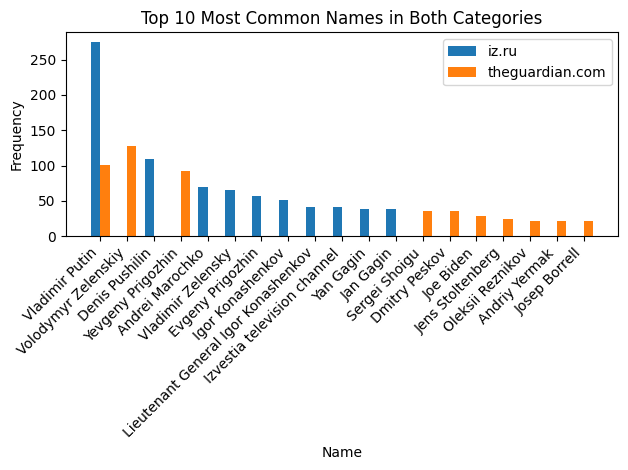

In [ ]:
import matplotlib.pyplot as plt

# Extract category names dynamically from most_common_names_data.keys()
categories = list(most_common_names_data.keys())

# Extract names and frequencies for each category
names_data = [most_common_names_data[category] for category in categories]

# Initialize lists to store names and frequencies for each category
names_category = [[] for _ in categories]
frequencies_category = [[] for _ in categories]

for i, names_count in enumerate(names_data):
    names, frequencies = zip(*names_count)
    names_category[i].extend(names)
    frequencies_category[i].extend(frequencies)

# Merge the lists of names, keeping unique names only
unique_names = list(set().union(*names_category))

# Get the frequencies for each unique name, filling with 0 if not present in a category
frequencies_combined_category = [
    [
        frequencies_category[i][names_category[i].index(name)] if name in names_category[i] else 0
        for name in unique_names
    ]
    for i in range(len(categories))
]

# Calculate the positions for bars
positions = range(len(unique_names))

# Initialize a list to store the total frequencies for each unique name
total_frequencies = [0] * len(unique_names)

# Calculate the total frequencies for each unique name across all categories
for i in range(len(categories)):
    total_frequencies = [total_frequencies[j] + frequencies_combined_category[i][j] for j in range(len(unique_names))]

# Sort the unique names by their total frequencies in descending order
sorted_names = [x for _, x in sorted(zip(total_frequencies, unique_names), reverse=True)]

# Width of each bar
bar_width = 0.35

# Create bars for each category based on the sorted names
for i in range(len(categories)):
    frequencies_sorted = [
        frequencies_combined_category[i][unique_names.index(name)] if name in unique_names else 0
        for name in sorted_names
    ]
    plt.bar(
        [pos + i * bar_width for pos in positions],
        frequencies_sorted,
        bar_width,
        label=categories[i],
    )

# Set x-axis labels and title using the sorted names
plt.xticks([pos + bar_width / 2 for pos in positions], sorted_names, rotation=45, ha='right')
plt.xlabel("Name")
plt.ylabel("Frequency")
plt.title("Top 10 Most Common Names in Both Categories")

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Visualisation of results: Most common affiliation

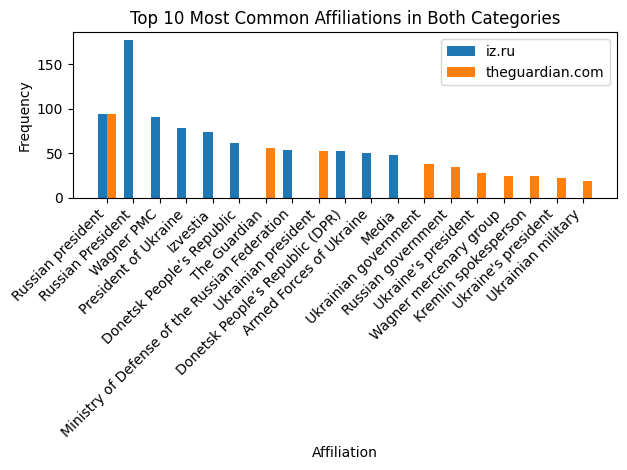

In [ ]:
import matplotlib.pyplot as plt

# Extract affiliations and frequencies for each category
affiliations_data = [most_common_affiliations_data[category] for category in categories]

# Initialize lists to store affiliations and frequencies for each category
affiliations_category = [[] for _ in categories]
frequencies_category = [[] for _ in categories]

for i, affiliations_count in enumerate(affiliations_data):
    affiliations, frequencies = zip(*affiliations_count)
    affiliations_category[i].extend(affiliations)
    frequencies_category[i].extend(frequencies)

# Merge the lists of affiliations, keeping unique affiliations only
unique_affiliations = list(set().union(*affiliations_category))

# Get the frequencies for each unique affiliation, filling with 0 if not present in a category
frequencies_combined_category = [
    [
        frequencies_category[i][affiliations_category[i].index(affiliation)] if affiliation in affiliations_category[i] else 0
        for affiliation in unique_affiliations
    ]
    for i in range(len(categories))
]

# Calculate the positions for bars
positions = range(len(unique_affiliations))

# Initialize a list to store the total frequencies for each unique affiliation
total_frequencies = [0] * len(unique_affiliations)

# Calculate the total frequencies for each unique affiliation across all categories
for i in range(len(categories)):
    total_frequencies = [total_frequencies[j] + frequencies_combined_category[i][j] for j in range(len(unique_affiliations))]

# Sort the unique affiliations by their total frequencies in descending order
sorted_affiliations = [x for _, x in sorted(zip(total_frequencies, unique_affiliations), reverse=True)]

# Width of each bar
bar_width = 0.35

# Create bars for each category based on the sorted affiliations
for i in range(len(categories)):
    frequencies_sorted = [
        frequencies_combined_category[i][unique_affiliations.index(affiliation)] if affiliation in unique_affiliations else 0
        for affiliation in sorted_affiliations
    ]
    plt.bar(
        [pos + i * bar_width for pos in positions],
        frequencies_sorted,
        bar_width,
        label=categories[i],
    )

# Set x-axis labels and title using the sorted affiliations
plt.xticks([pos + bar_width / 2 for pos in positions], sorted_affiliations, rotation=45, ha='right')
plt.xlabel("Affiliation")
plt.ylabel("Frequency")
plt.title("Top 10 Most Common Affiliations in Both Categories")

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Visualisation of results: Most common affiliation types

In [ ]:
from collections import Counter, defaultdict  # Import defaultdict from collections module

# Initialize dictionaries to store data for each source category
category_data = {category: {"affiliation_types": []} for category in source_category}

# Parse JSON and collect "affiliation_type" values using list comprehensions
for i, response in enumerate(responses):
    data = json.loads(response)
    category = source_category[i]

    sources = data.get("sources", [])
    for source in sources:
        affiliation_type = source.get("affiliation_type", "")
        category_data[category]["affiliation_types"].append(affiliation_type)

# Calculate the share of documents with each "affiliation_type" in each category using defaultdict and list comprehensions
share_data = defaultdict(lambda: defaultdict(float))

for category, c_data in category_data.items():
    affiliation_types = c_data["affiliation_types"]
    total_documents = len(affiliation_types)
    affiliation_type_counts = Counter(affiliation_types)

    for affiliation_type, count in affiliation_type_counts.items():
        share_data[category][affiliation_type] = count / total_documents

# Convert the defaultdict to a regular dictionary for easier plotting
share_data = dict(share_data)

# Create a DataFrame for easier plotting
df = pd.DataFrame(share_data)

In [ ]:
df.head(20)

,iz.ru,theguardian.com
Media,0.210856,0.089793
University,0.004871,0.005986
Russian military,0.060195,0.024244
Ukrainian government,0.098469,0.244538
Russian government,0.246347,0.189165
Civil society or independent expert,0.096729,0.096977
US government,0.007655,0.023346
Military,0.002436,0.002993
Russian Government,0.093250,0.009578
Ukrainian military,0.096033,0.061957


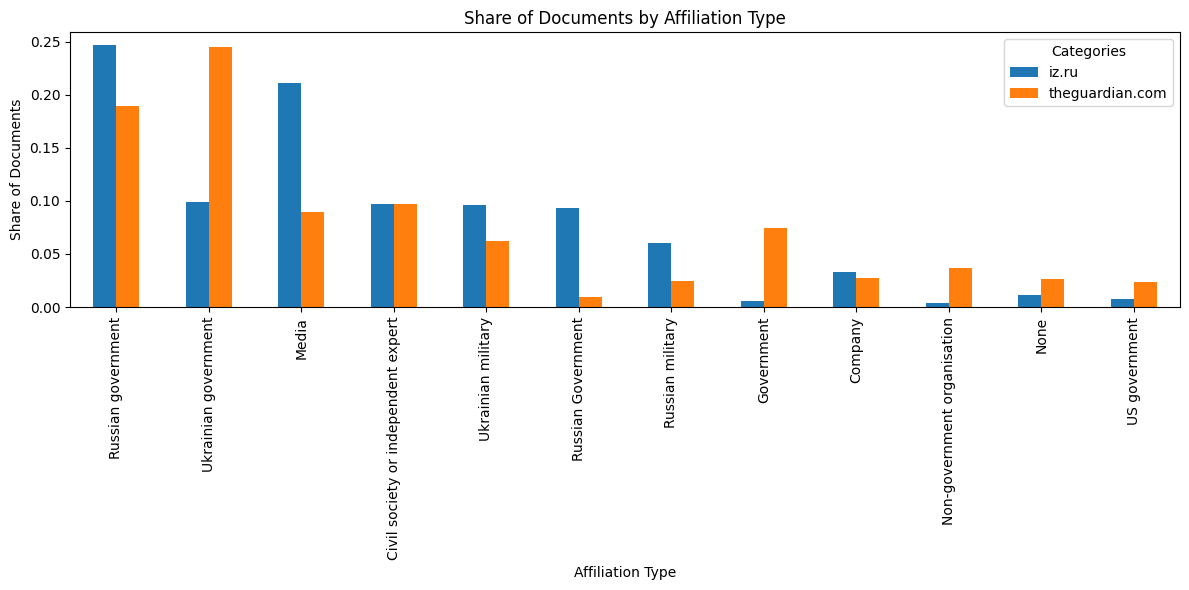

In [ ]:
# Filter rows where at least one category has a share of at least 2%
filtered_df = df[(df >= 0.02).any(axis=1)]

# Sort the filtered data by the sum of shares in descending order
filtered_df = filtered_df.loc[filtered_df.sum(axis=1).sort_values(ascending=False).index]

# Create a bar plot comparing the categories for the filtered data with bars next to each other
ax = filtered_df.plot(kind='bar', figsize=(12, 6))
ax.set_xlabel("Affiliation Type")
ax.set_ylabel("Share of Documents")
ax.set_title("Share of Documents by Affiliation Type")
ax.legend(title="Categories", labels=filtered_df.columns)

# Show the plot
plt.tight_layout()
plt.show()